# Naive Classifier for Fake news recognition

## Packages

In [92]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)

## Reading the data

In [2]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [3]:
train2.filename <- 'dataset/fake-news/train.csv'
test2.filename <- 'dataset/fake-news/test.csv'

In [4]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

In [5]:
# train2.df <- read.delim(train2.filename, sep = ',')
# test2.df <- read.delim(test2.filename, sep = ',')

## Display the train and test datasets

In [6]:
head(test.df)

Text                                                                                                                                                 
1 Building a wall on the U.S.-Mexico border will take literally years.                                                                                 
2 Wisconsin is on pace to double the number of layoffs this year.                                                                                      
3 Says John McCain has done nothing to help the vets.                                                                                                  
4 Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.                                                                
5 When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.                      
6 Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.
  Text_Tag                                          
1 immigration                                       
2 jobs                                              
3 military,veterans,voting-record                   
4 medicare,message-machine-2012,campaign-advertising
5 campaign-finance,legal-issues,campaign-advertising
6 federal-budget,pensions,retirement

In [7]:
head(train.df)

Labels
1 1     
2 2     
3 3     
4 1     
5 2     
6 5     
  Text                                                                                                                                                       
1 Says the Annies List political group supports third-trimester abortions on demand.                                                                         
2 When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.              
3 Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."                                                  
4 Health care reform legislation is likely to mandate free sex change surgeries.                                                                             
5 The economic turnaround started at the end of my term.                                                                                                     
6 The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.
  Text_Tag                          
1 abortion                          
2 energy,history,job-accomplishments
3 foreign-policy                    
4 health-care                       
5 economy,jobs                      
6 education

In [8]:
# head(train2.df)

In [9]:
# head(test2.df)

# Splitting the datasets

In [10]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [11]:
# set splitting percentages
perc_split<- 0.8  # set splitting percentages
n_rows<- nrow(train.df)
n_rows_train<-floor(n_rows*perc_split)

In [12]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [13]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

# Vocabulary creation

In [14]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

In [15]:
colnames(train.df.train)

[1] "Labels"   "Text"     "Text_Tag"

In [16]:
train.df.train %>%
    select(Text) %>%
    unnest_tokens(word, Text) %>%
    anti_join(get_stopwords(), by = join_by(word)) %>%
    unique %>%
    arrange(word) -> vocabulary.train  #%>% filter(grepl('', word))

In [62]:
train.df.train %>% select(Text) %>% filter(grepl('-', Text))

Text                                                                                                                                                                                                                                                                                    
1    Says a poll found him the only Republican candidate who could beat Barack Obama in Texas -- and by eight points.                                                                                                                                                                        
2    Says Rick Perry flip-flopped on gay marriage by first saying it was a states rights issue and then saying he was in favor of a federal constitutional amendment banning gay marriage.                                                                                                   
3    The United States death rate is two-and-a-half times higher for those who do not have a high school education.                                                                                                                                                                          
4    The largest category of people coming into the technical schools in Wisconsin are people with four-year degrees.                                                                                                                                                                        
5    A proposed mine in Wisconsin is about two-thirds the size of Lake Winnebago.                                                                                                                                                                                                            
6    The cost of health care is now the single-biggest factor driving down the federal budget deficit.                                                                                                                                                                                       
7    The Libertarian Party is the third-largest political party in the U.S.                                                                                                                                                                                                                  
8    The right-to-work states are creating a lot more jobs today than the heavily unionized states.                                                                                                                                                                                          
9    The 30 percent tax rate called for under President Barack Obamas proposed Buffett Rule is lower than the prescribed tax rate for millionaires already -- not just for millionaires, for people making over $200,000.                                                                    
10   PolitiFact Texas gave a David Dewhurst TV ad a Pants-on-Fire rating as an outrageous lie.                                                                                                                                                                                               
11   If your plan is the result of collective bargaining, no subsequent changes by anybody -- insurance companies, Obamacare -- can force your grandfathered policy to change.                                                                                                               
12   If all of the [Bush-era] tax cuts expire on schedule, the budget will be close to being balanced in four years.                                                                                                                                                                         
13   Says Travis Countys unemployment rate is below the national average while its poverty rate exceeds the national average--and local poverty is rising.                                                                                                                                   
1

In [21]:
vocabulary.train

word       
1     0          
2     0.05       
3     0.1        
4     0.25       
5     0.47       
6     0.7        
7     0.9        
8     02         
9     04         
10    06         
11    1          
12    1,000      
13    1,033      
14    1,100      
15    1,200      
16    1,300      
17    1,336      
18    1,399      
19    1,400      
20    1,500      
21    1,525      
22    1,540      
23    1,547      
24    1,600      
25    1,650      
26    1,700      
27    1,761      
28    1,773      
29    1,800      
30    1,900      
⋮     ⋮          
11353 youth      
11354 youths     
11355 youtube    
11356 youve      
11357 yrs        
11358 yucca      
11359 yulin      
11360 yuma       
11361 yuri       
11362 z          
11363 zack       
11364 zandi      
11365 zanesville 
11366 zawahiri   
11367 zeldin     
11368 zell       
11369 zenzinger  
11370 zero       
11371 zika       
11372 zimmerman  
11373 zinn       
11374 zip        
11375 zippo      
11376 zombie     
11377 zombies    
11378 zone       
11379 zones      
11380 zoning     
11381 zoo        
11382 zuckerbergs

In [22]:
nrow(vocabulary.train)

[1] 11382

# Cleaning functions

In [37]:
remove_last_s <- function(token) {
    if (endsWith(token, "s")) {
        token <- substr(token, 1, nchar(token) - 1)
    }
    return(token)
}

In [38]:
remove_saxon_genitive<-function(token){
    token<-remove_last_s(token)
    if (endsWith(token, "'")) {
        token <- substr(token, 1, nchar(token) - 1)
    }
    return(token)
}

In [86]:
classify_as_numbers<-function(token){
    if(str_detect(token, "[0-9]+")){
        token<-'--number--'
    }
    return(token)
}

# Clean the vocabulary

In [94]:
vocabulary.train 

word       
1     0          
2     0.05       
3     0.1        
4     0.25       
5     0.47       
6     0.7        
7     0.9        
8     02         
9     04         
10    06         
11    1          
12    1,000      
13    1,033      
14    1,100      
15    1,200      
16    1,300      
17    1,336      
18    1,399      
19    1,400      
20    1,500      
21    1,525      
22    1,540      
23    1,547      
24    1,600      
25    1,650      
26    1,700      
27    1,761      
28    1,773      
29    1,800      
30    1,900      
⋮     ⋮          
11353 youth      
11354 youths     
11355 youtube    
11356 youve      
11357 yrs        
11358 yucca      
11359 yulin      
11360 yuma       
11361 yuri       
11362 z          
11363 zack       
11364 zandi      
11365 zanesville 
11366 zawahiri   
11367 zeldin     
11368 zell       
11369 zenzinger  
11370 zero       
11371 zika       
11372 zimmerman  
11373 zinn       
11374 zip        
11375 zippo      
11376 zombie     
11377 zombies    
11378 zone       
11379 zones      
11380 zoning     
11381 zoo        
11382 zuckerbergs

In [93]:
vocabulary.train %>% map(classify_as_numbers)

ERROR: [1m[33mError[39m in `map()`:[22m
[1m[22m[36mℹ[39m In index: 1.
[36mℹ[39m With name: word.
[1mCaused by error in `if (str_detect(token, "[0-9]+")) ...`:[22m
[33m![39m the condition has length > 1


#### Some suggestion to create equivalence classes

In [24]:
vocabulary.train %>%
    filter(grepl("al", word)) %>%
    head

word        
1 acalifornia 
2 accidental  
3 accidentally
4 accruals    
5 actalters   
6 actual

In [25]:
vocabulary.train %>%
    filter(grepl("\\'s", word))

word            
1  aba's           
2  abc's           
3  administration's
4  aig's           
5  alabama's       
6  america's       
7  arizona's       
8  ayers's         
9  biden's         
10 bill's          
11 bush's          
12 child's         
13 children's      
14 clinton's       
15 cnbc's          
16 colleague's     
17 country's       
18 crist's         
19 earth's         
20 florida's       
21 fred's          
22 geithner's      
23 giuliani's      
24 governor's      
25 guy's           
26 hillary's       
27 hutchison's     
28 individual's    
29 iran's          
30 jessen's        
31 john's          
32 leadership's    
33 limbaugh's      
34 man's           
35 mccain's        
36 member's        
37 mica's          
38 mobil's         
39 nation's        
40 obama's         
41 oil's           
42 party's         
43 perry's         
44 president's     
45 rezko's         
46 romney's        
47 rubio's         
48 school's        
49 scott's         
50 security's      
51 senate's        
52 someone's       
53 sotomayor's     
54 state's         
55 teacher's       
56 tenet's         
57 woman's         
58 women's         
59 world's

In [21]:
train.df %>%
    filter(grepl("06", Text)) %>%
    filter(!grepl("2006", Text))  #%>% summarise(n())

Labels
1 2     
2 3     
3 0     
4 5     
5 4     
6 2     
  Text                                                                                                                                                         
1 Americans bought into climate change in 2004-06, but then most began wandering away from this issue.                                                         
2 Says Rep. Paul Ryans budget roadmap doesnt balance the budget until the 2060s and adds an unthinkable $62 trillion to the national debt between now and then.
3 They were going to build the wall a while ago, not so long ago, like in 06. And they couldnt get environmental impact statements.                            
4 Over the last six months, President Barack Obama has golfed 10 times and held 106 fundraisers, but his jobs council has never met.                           
5 In one county alone in Ohio, President Obama received 106,258 votes. But there were only 98,213 eligible voters.                                             
6 The Republicans didn't have a budget in '02, '04, '06.                                                                                                       
  Text_Tag                                                 
1 climate-change,environment,polls                         
2 deficit,federal-budget                                   
3 immigration                                              
4 campaign-finance,economy,jobs,message-machine-2012,sports
5 elections                                                
6 federal-budget,abc-news-week

## About the data

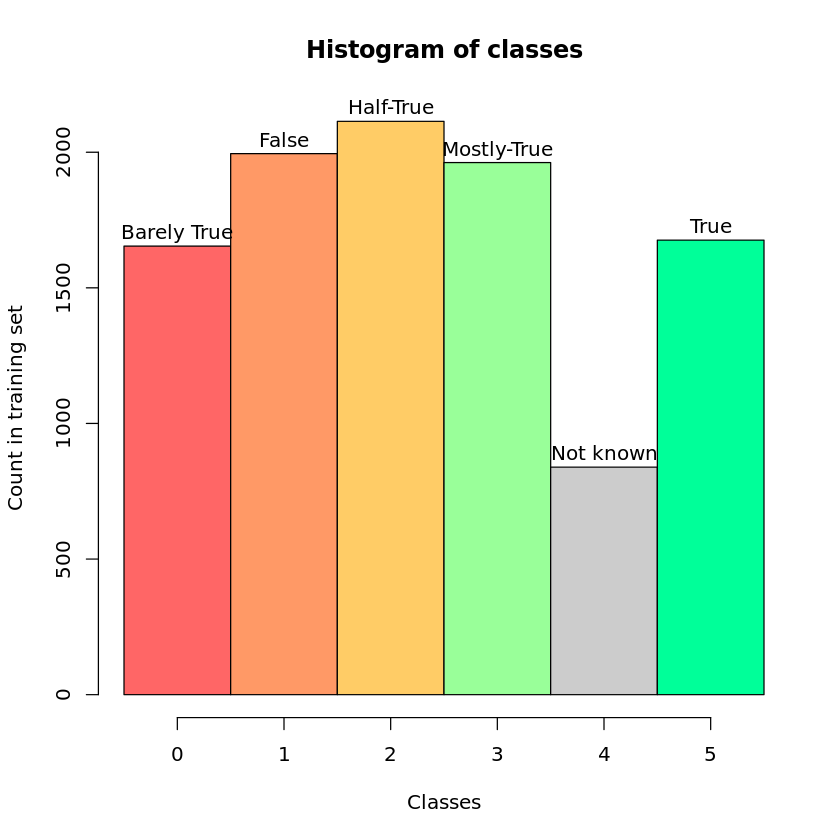

In [22]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

hist(x = train.df$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

# Count how many topics there are

In [23]:
train.df.train %>%
    select(Text_Tag) %>%
    unnest_tokens(word, Text_Tag, token = stringr::str_split, pattern = ",") %>%
    unique %>%
    arrange(word) -> topics

In [24]:
train.df.train  %>% filter(Text_Tag=='')

Labels
1 1     
  Text                                                                                                                                                                                                                                                                                    
1 Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.''\thealth-care,taxes\trichard-durbin\tSenator\tIllinois\tdemocrat\t0\t2\t1\t0\t1\ta comment on the Morning Joe'' show on MSNBC.
  Text_Tag
1

In [25]:
topics<-as.list(topics)$word

#### Number of unique topics

In [26]:
length(topics)

[1] 143

#### Most frequent and infrequent topics

In [27]:
counts<-vector()
for(i in seq_along(topics)){
    counts[i]<- as.numeric(train.df.train %>% filter(grepl(topics[i], Text_Tag)) %>% summarise(n()))
    }

In [28]:
topics_counts <- data.frame(topics, counts)

In [29]:
topics_counts %>%
    filter(topics != "") %>%
    arrange(desc(counts)) %>%
    head()

topics         counts
1 economy        928   
2 health-care    904   
3 taxes          808   
4 federal-budget 584   
5 education      582   
6 jobs           570

In [30]:
topics_counts %>%
    arrange(counts) %>%
    head()

topics         counts
1 alcohol        0     
2 death-penalty  1     
3 fires          1     
4 homeless       1     
5 after-the-fact 2     
6 autism         3